In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from scipy import stats

In [2]:
from transformers import AutoTokenizer, AutoModel
from bert_transformer import BertTransformer

tokenizer = AutoTokenizer.from_pretrained('allegro/herbert-base-cased')
bert_model = AutoModel.from_pretrained("allegro/herbert-base-cased") 

c:\Users\Lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.sso.sso_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertM

In [3]:
X_string = 'nlp_3', # TUPLE
Y_string = 'GDT_score'
DATASET = 'NLP_FULLSTOPS.xlsx'

In [4]:
df = pd.read_excel(io=DATASET)

bert_transformer = BertTransformer(tokenizer, bert_model, max_length=60)

In [5]:
all_x = []

for item in X_string:

    item_processed = bert_transformer.transform(list(df[item]))
    all_x.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

all_x = tuple(all_x)
X = np.hstack(all_x)

y = df[Y_string]
X.shape


nlp_3 added to list


(522, 768)

In [6]:
pilot_df = pd.read_excel('NLP_PILOT.XLSX')

pilot_X = []

for item in X_string:

    item_processed = bert_transformer.transform(list(pilot_df[item]))
    pilot_X.append(item_processed)
    print(f'{item} added to list')
    time.sleep(0.5)

pilot_X = tuple(pilot_X)
pilot_X = np.hstack(pilot_X)

pilot_Y = pilot_df[Y_string]
pilot_X.shape

nlp_3 added to list


(95, 768)

In [52]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True, random_state=1)

true_data = []
results = []


for train_index, test_index in kfold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model = tf.keras.Sequential([
                            tf.keras.layers.Dense(32, activation='sigmoid'),
                            tf.keras.layers.Dense(16, activation='relu'),
                            tf.keras.layers.Dense(units=1)
                            ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')

    model.fit(X_train, y_train, batch_size=32, epochs=100, verbose=0)    
    result = model.predict(X_test)

    result = [float(item) for item in result]
    results = np.concatenate((results, result))
    true_data = np.concatenate((true_data, y_test))

    print(stats.pearsonr(result, y_test))

2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.39599042003670304, pvalue=0.0033341166604392686)
2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.21701723286603136, pvalue=0.11854664987471089)
2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.15563143020741718, pvalue=0.2705823827675791)
2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.331443327370202, pvalue=0.01638387918605484)
2/2 [==============================] - 0s 5ms/step
PearsonRResult(statistic=0.22866102836760197, pvalue=0.10299633766572602)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.28869733814276066, pvalue=0.03792705429824386)
2/2 [==============================] - 0s 0s/step
PearsonRResult(statistic=0.2858476035232813, pvalue=0.039951651571275074)
2/2 [==============================] - 0s 10ms/step
PearsonRResult(statistic=0.43015365057028887, pvalue=0.0014585263558307441)
2/

In [53]:
#WHOLE DATASET

results = [item if item >= 4 else 4 for item in results]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, true_data))

PearsonRResult(statistic=0.3157389779456701, pvalue=1.5100377321445782e-13)


In [ ]:
answers_tuples = [(y, res) for y, res in zip(true_data, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

true_data = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

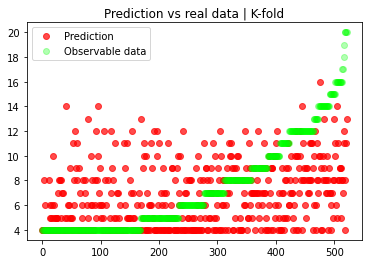

In [ ]:
plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(true_data)), true_data, 'o', color=[0, 1, 0, 0.3], label='Observable data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | K-fold')
plt.show()

In [ ]:
# Using model to predict pilot data

model = tf.keras.Sequential([
                            tf.keras.layers.Dense(32, activation='sigmoid'),
                            tf.keras.layers.Dense(16, activation='relu'),
                            tf.keras.layers.Dense(units=1)
                            ])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_absolute_error')
model.fit(X, y, batch_size=64, epochs=100, verbose=0)

In [ ]:
prediction = model.predict(pilot_X)
prediction = [float(item) for item in prediction]
results = [item if item >= 4 else 4 for item in prediction]
results = [item if item <= 20 else 20 for item in results]

print(stats.pearsonr(results, pilot_Y))

3/3 [==============================] - 0s 3ms/step
PearsonRResult(statistic=0.17405775101293236, pvalue=0.09161307436327316)


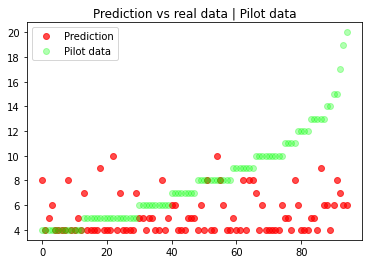

In [ ]:
answers_tuples = [(y, res) for y, res in zip(pilot_Y, results)]
sorted_tuples = sorted(answers_tuples, key=lambda x: x[0])

test_y = [x[0] for x in sorted_tuples]
result = [x[1] for x in sorted_tuples]

rounded_result = [round(int(item)) for item in result]

plt.plot(range(len(result)), rounded_result, 'o', color=[1, 0, 0, 0.7], label="Prediction")
plt.plot(range(len(test_y)), test_y, 'o', color=[0, 1, 0, 0.3], label='Pilot data')
plt.legend(loc='upper left')
plt.title('Prediction vs real data | Pilot data')
plt.show()